<a href="https://colab.research.google.com/github/CoolPandaWang/BinglovePing.github.io/blob/main/IP_CW1_1123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Thresholding

### Convert the image to a gray image

Import packages (all packages in this notebook)

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# to visualize the plots within the notebook
%matplotlib inline 

Load Image

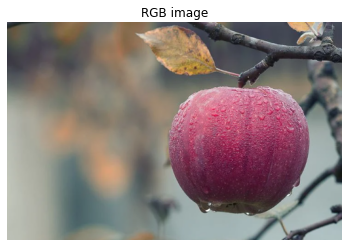

In [ ]:
img_path = 'source.png' # Change here for your image file path
img_apple = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img_apple = img_apple[:, :, [2, 1, 0]] # In opencv, the channel is BGR, so I change the channel to RGB
plt.figure()
plt.title('RGB image')
plt.axis('off')
plt.imshow(img_apple)

In [ ]:
def to_gray(img):
    '''
    Convert and RGB image into gray scale
    :param img: RBG image with size HxWx3
    :return: gray scaled image of size HxW
    '''
    # imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B.
    assert len(img.shape) == 3, f'Wrong input image dimensions, we expected an input of size HxWxC instead we got {img.shape}'
    h,w,c = img.shape
    gray_img = 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:, 2] # Modify this part to convert the image onto gray scale
    assert gray_img.shape == (h,w), 'Wrong spacial dimensions, your method should only change the channel dimension'
    return gray_img.astype('int')


Image dimensions: (332, 511, 3) 
Gray scale image dimensions: (332, 511)


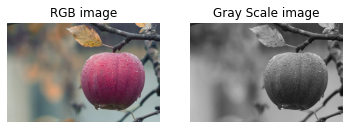

In [ ]:
gray_apple = to_gray(img_apple)
print('Image dimensions:', img_apple.shape, '\nGray scale image dimensions:', gray_apple.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('RGB image')
plt.axis('off')
plt.imshow(img_apple)
plt.subplot(1, 2, 2)
plt.title('Gray Scale image')
plt.axis('off')
plt.imshow(gray_apple, cmap = 'gray')

### Threshold the image by a threshold value t

In [ ]:
def threshold(img, t):
    thre_output = img.copy()
    # Image pixel value from 0 to 255
    thre_output[img < t] = 1
    thre_output[img >= t] = 0
    return thre_output

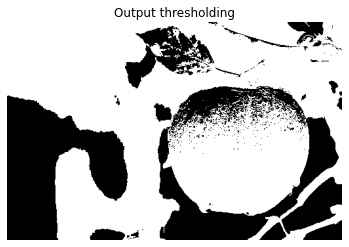

In [ ]:
# threshold value t
t = 140
thre_output = threshold(gray_apple, t)
# Thresholding by t
plt.figure()
plt.title('Output thresholding')
plt.axis('off')
plt.imshow(thre_output, cmap = 'gray')


### Plot the ROC curve of that method under varying t

Load ground truth image

In [ ]:
gt_img_path = 'target.png' # Change here for your image file path
gt_apple = cv2.imread(gt_img_path, cv2.IMREAD_GRAYSCALE)
gt_apple[gt_apple == 255] = 1

ROC Curve

Binary classifiers are evaluated a test dataset that comprises of positive data and negative data. Majority of pervious works in literature [1, 2, 3] used Receiver Operating Characteristics (ROC) curve to report performance.

ROC curve is a 2D curve. The x axis is the FPR, y axis is the TPR

Where, TPR = Number of correct positive prediction (TP) / positive prediction (P)

FPR = Number of incorrect negative prediction (FN) / negative prediction (N)

And AUC-ROC curve (area under the ROC curve) is a commonly used metric to evaluate the performance of binary classifer. The AUC-ROC of random guessing is 0.5. So, a good model AUC-ROC should larger than 0.5. 

In [ ]:
# Calculate TP TN FP FN for a segmentation result compare to the ground truth
def evaluation_value(img, gt):
    TP, TN, FP, FN = (0, 0, 0, 0) 
    P = gt[img == 1]
    TP = P[P == 1].shape[0]
    FP = P.shape[0] - TP
    N = gt[img == 0]
    TN = N[N == 0].shape[0]
    FN = N.shape[0] - TN
    return TP, TN, FP, FN

In [ ]:
# Calculate the AUC (area under ROC curve)
# We can use the composite trapezoidal rule to calculate Integrate 
# Where Intergrate is the area under curve
def auc(x, y):
    direction = 1
    dx = np.diff(x)
    # array need to increase or decrease
    if np.any(dx < 0):
        if np.all(dx <= 0):
            direction = -1
        else:
            raise ValueError("x is neither increasing nor decreasing : {}.".format(x))
    area = direction * np.trapz(y, x)
    if isinstance(area, np.memmap):
        area = area.dtype.type(area)
    return area

In [ ]:
def ROC(img, gt):    
    TPR = []
    FPR = []
    TP_list, TN_list, FP_list, FN_list, t_value = ([], [], [], [], [])
    # Sample thresholding value to calculate FPR and TPR
    for t in range(0, 255):
        valuet = t
        thre_output = threshold(img, valuet)
        # T is true prediction, F is the false prediction
        # P is the prediction is positive, N is the prediction is negative
        # In this part P is apple, N is nonapple.
        TP, TN, FP, FN = evaluation_value(thre_output, gt.copy())
        current_TPR = 0
        if TP + FN != 0: # In case no prediction of negative
            current_TPR = TP / (TP + FN) # TPR = TP / P
        current_FPR = 0
        if FP + TN != 0: # In case no prediction of negative
            current_FPR = FP / (FP + TN) # TPR = TP / N
        TPR.append(current_TPR)
        FPR.append(current_FPR)
        TP_list.append(TP)
        TN_list.append(TN) 
        FP_list.append(FP) 
        FN_list.append(FN)
        t_value.append(t)
    
    return TP_list, TN_list, FP_list, FN_list, TPR, FPR, t_value

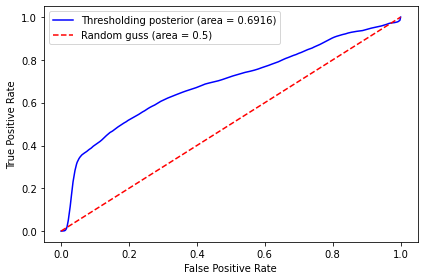

In [ ]:
TP_list, TN_list, FP_list, FN_list, TPR, FPR, t_value = ROC(gray_apple, gt_apple)
FPR = np.array(FPR)
TPR = np.array(TPR)
roc_auc = auc(FPR, TPR)

plt.figure()
plt.plot(FPR,  TPR, 'b-', label="Thresholding posterior (area = %0.4f)" % roc_auc)
plt.plot([i * 0.1 for i in range(0, 11)], [i * 0.1 for i in range(0, 11)], 'r--', label = "Random guss (area = 0.5)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

### Optimal threshold t, when precision and recall are weighted equally

Optimal threshold t: 82 (when precision and recall are weighted equally)


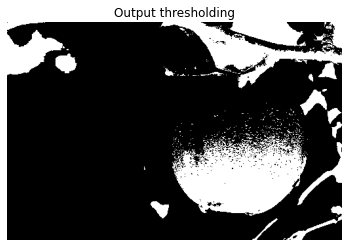

In [ ]:
# Sensitivity, recall, hit rate, or true positive rate (TPR)
# TPR = recall = TP / (TP + FN)
# Precision or positive predictive value (PPV)
# PPV = Precision = TP / (TP + FP)
# F1 score is the harmonic mean of precision and sensitivity:
# F1 = (2 * TP) / (2 * TP + FP + FN)
best_t = 0
max_tmp = 0.0
for i in range(len(TP_list)):
    F1_score = (2 * TP_list[i]) / (2 * TP_list[i] + FP_list[i] + FN_list[i])
    if F1_score > max_tmp:
        best_t = t_value[i]
        max_tmp = F1_score
        
print('Optimal threshold t:', best_t, '(when precision and recall are weighted equally)')
thre_output = threshold(gray_apple, best_t)
# Thresholding by t
plt.figure()
plt.title('Output thresholding')
plt.axis('off')
plt.imshow(thre_output, cmap = 'gray')

### Better linear method

In [ ]:
def to_gray_better(img):
    '''
    Convert and RGB image into gray scale
    :param img: RBG image with size HxWx3
    :return: gray scaled image of size HxW
    '''
    # imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B.
    assert len(img.shape) == 3, f'Wrong input image dimensions, we expected an input of size HxWxC instead we got {img.shape}'
    h,w,c = img.shape
    gray_img = 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:, 2] # Modify this part to convert the image onto gray scale
    assert gray_img.shape == (h,w), 'Wrong spacial dimensions, your method should only change the channel dimension'
    return gray_img.astype('int')


Image dimensions: (332, 511, 3) 
Gray scale image dimensions: (332, 511)


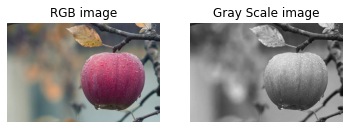

In [ ]:
gray_apple_better = to_gray_better(img_apple)
print('Image dimensions:', img_apple.shape, '\nGray scale image dimensions:', gray_apple_better.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('RGB image')
plt.axis('off')
plt.imshow(img_apple)
plt.subplot(1, 2, 2)
plt.title('Gray Scale image')
plt.axis('off')
plt.imshow(gray_apple_better, cmap = 'gray')

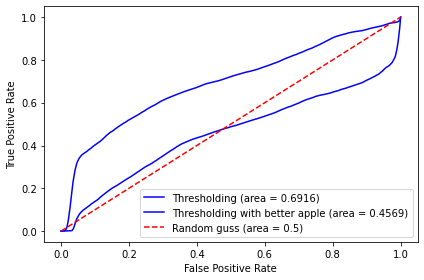

In [ ]:
TP_list, TN_list, FP_list, FN_list, TPR, FPR, t_value = ROC(gray_apple, gt_apple)
FPR = np.array(FPR)
TPR = np.array(TPR)
roc_auc = auc(FPR, TPR)

plt.figure()
plt.plot(FPR,  TPR, 'b-', label="Thresholding (area = %0.4f)" % roc_auc)

TP_list, TN_list, FP_list, FN_list, TPR, FPR, t_value = ROC(gray_apple_better, gt_apple)
FPR = np.array(FPR)
TPR = np.array(TPR)
roc_auc = auc(FPR, TPR)
plt.plot(FPR,  TPR, 'b-', label="Thresholding with better apple (area = %0.4f)" % roc_auc)
plt.plot([i * 0.1 for i in range(0, 11)], [i * 0.1 for i in range(0, 11)], 'r--', label = "Random guss (area = 0.5)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

# 2. Clustering

## K-means

### Load image

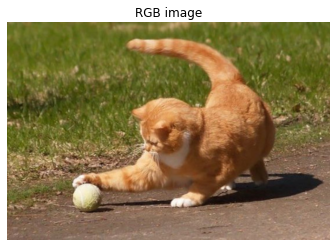

In [ ]:
img_path = 'clustering.png' # Change here for your image file path
img_cat = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img_cat = img_cat[:, :, [2, 1, 0]] # In opencv, the channel is BGR, so I change the channel to RGB
plt.figure()
plt.title('RGB image')
plt.axis('off')
plt.imshow(img_cat)

### K-means

In [ ]:
def Kmeans(n_clusters, data, n_iteration = 300):
    '''
    Input:
    data         the dataset with shape (n, d), n is the number of data, d is the demention of data
    n_clusters   a number is the hyperparameter K of K-Means. K-Means will find K clusters centers
    
    Output:
    labels       the each data belong to the classes with shape (n)
    centers      the clusters centers with shape (n_clusters, d)
    '''
    # 1. Randomly initialize cluster means
    nData, nDims = data.shape
    labels = np.zeros(shape = (nData)).astype('int')
    centers = np.random.normal(loc = 128, scale = 100, size = (1, n_clusters, nDims)) # (1, d, k)
    data_K = np.array([data.T for i in range(n_clusters)]).T # (n, d, k)
    eps = 1e-3

    for i in range(n_iteration):
        # 2. Compute distances 𝐷𝑛1,𝐷𝑛2, … ,𝐷𝑛𝐾 for each object 𝒙𝑛 to all 𝐾 cluster means
        data_minus_centers = data_K - centers # (n, d, k)
        sq = np.square(data_minus_centers) # squared Euclidean distance
        dis = np.sum(sq, axis = 1) # (k, n) 
        
        # 3. Assign the object 𝒙𝑛 to cluster 𝑘 with lowest distance 𝐷𝑛k 
        labels = np.argmin(dis, axis = 0) # (n)

        # 4. Update each cluster mean 𝝁𝑘, to represent the mean of newly updated cluster
        newcenters = centers.copy()
        for K in range(n_clusters):
            cur_labels = labels == K
            num = cur_labels.shape[0]
            if num == 0:
                continue
            newcenters[:, cur_labels, :] = np.mean(data[cur_labels, :], axis = 0).reshape(1, nDims) 
        # Stop if assignments don’t change
        updated_sum = np.sum(newcenters - centers)
        if updated_sum < eps:
            break
        centers = newcenters
    
    centers = centers.reshape(n_clusters, nDims)
    
    return labels, centers 

In [ ]:
from sklearn.cluster import KMeans

### K-means by color

In [ ]:
data_RGB = img_cat.copy().transpose(2,0,1).reshape(3,-1)
data_RGB = data_RGB.T
print(data_RGB.shape)
kmeans_RGB = KMeans(n_clusters=4).fit(data_RGB)
labels_RGB = kmeans_RGB.labels_
clusters_RGB = kmeans_RGB.cluster_centers_

(1429792, 3)


(1429792,)


(-0.5, 1455.5, 981.5, -0.5)

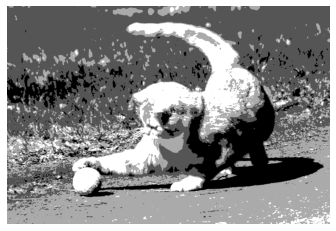

In [ ]:
print(labels_RGB.shape)
output = labels_RGB.copy().reshape(img_cat.shape[0], img_cat.shape[1])
plt.figure()
plt.axis('off')

plt.imshow(output)

### K-means by color and positions

In [ ]:
data_RGBXY = img_cat.copy().transpose(2,0,1).reshape(3,-1).T
position = np.zeros(shape = (data_RGBXY.shape[0], 2))
for x in range(img_cat.shape[0]):
    for y in range(img_cat.shape[1]):
        position[x * img_cat.shape[1] + y, :] =  np.array([x / img_cat.shape[0] * 110 , y / img_cat.shape[1] * 110])

data_RGBXY = np.append(data_RGBXY, position, axis = 1)

print(data_RGBXY.shape)
kmeans_RGBXY = KMeans(n_clusters=4).fit(data_RGBXY)
labels_RGBXY = kmeans_RGBXY.labels_
clusters_RGBXY = kmeans_RGBXY.cluster_centers_

(1429792, 5)


(1429792,)


(-0.5, 1455.5, 981.5, -0.5)

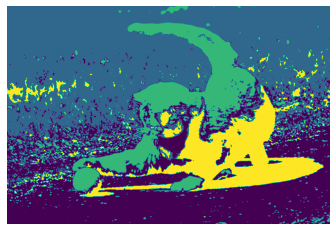

In [ ]:
print(labels_RGBXY.shape)
output = labels_RGBXY.copy().reshape(img_cat.shape[0], img_cat.shape[1])
plt.figure()
plt.imshow(output)
plt.axis('off')

## L2 error

In [ ]:
def L2_Error(x, y):
    return np.mean((y - x) * (y - x))

In [ ]:
def calculate_l2(labels, clusters, data):
    k = clusters.shape[0]
    clusters_data = np.zeros(shape = data.shape)
    for i in range(k):
        clusters_data[labels == i, :] = clusters[i, :]
    return L2_Error(clusters_data, data)

In [ ]:
RGB_l2loss = calculate_l2(labels_RGB, clusters_RGB, data_RGB)
RGBXY_l2loss = calculate_l2(labels_RGBXY, clusters_RGBXY[:, 0:3], data_RGB)
print('RGB l2 loss = ', RGB_l2loss, '\nRGB position l2 loss = ', RGBXY_l2loss)

RGB l2 loss =  283.89049006594115 
RGB position l2 loss =  336.6771319539571


## Test different K for K-Means

In [ ]:
RGB_losses = []
RGBXY_losses = []
nK = 100
for K in range(1, nK + 1):
    # RGB
    kmeans_RGB = KMeans(n_clusters=K).fit(data_RGB)
    labels_RGB = kmeans_RGB.labels_
    clusters_RGB = kmeans_RGB.cluster_centers_
    # RGBXY
    kmeans_RGBXY = KMeans(n_clusters=K).fit(data_RGBXY)
    labels_RGBXY = kmeans_RGBXY.labels_
    clusters_RGBXY = kmeans_RGBXY.cluster_centers_
    # Calculate losses
    RGB_l2loss = calculate_l2(labels_RGB, clusters_RGB, data_RGB)
    RGB_losses.append(RGB_l2loss)
    RGBXY_l2loss = calculate_l2(labels_RGBXY, clusters_RGBXY[:, 0:3], data_RGB)
    RGBXY_losses.append(RGBXY_l2loss)
    
    if K % 2 == 0:
        print('Done interation ', K, '/', nK)

plt.figure()
plt.plot([K for K in range(1, nK + 1)], RGB_losses, 'r-', label = 'RGB l2 loss')
plt.plot([K for K in range(1, nK + 1)], RGBXY_losses, 'g-', label = 'RGBXY l2 loss')
plt.xlabel('Number of clusters')
plt.ylabel('L2 error bewteen image and clusters')
plt.legend()
plt.show()

Done interation  2 / 100
Done interation  4 / 100
Done interation  6 / 100
Done interation  8 / 100
Done interation  10 / 100
Done interation  12 / 100
Done interation  14 / 100
Done interation  16 / 100
Done interation  18 / 100
Done interation  20 / 100
Done interation  22 / 100
Done interation  24 / 100
Done interation  26 / 100
Done interation  28 / 100
Done interation  30 / 100
Done interation  32 / 100
Done interation  34 / 100
Done interation  36 / 100
Done interation  38 / 100
Done interation  40 / 100
Done interation  42 / 100
Done interation  44 / 100
Done interation  46 / 100
Done interation  48 / 100
Done interation  50 / 100
